# HW3 - Measuring Gender Bias in Pretrained Language Model on Named Entity Recognition - DSCI 531 - Spring 2023

### Please complete the code or analysis under “TODO”. 100pts in total. You should run every cell and keep all the outputs before submitting. Failing to include your outputs will result in zero points.

### Please keep in mind the academic integrity. Plagiarism will be taken seriously.

## Name: Nandini Nag

## USC ID: 8309782868

## Example of using a finetuned BERT on NER

In [2]:
!pip install transformers

In [3]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [92]:
import torch
import os
import pandas as pd
import numpy as np
import csv
import time

In [82]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

# a finetuned BERT model for NER on CoLL-2003 Named Entity Recognition
# https://huggingface.co/dslim/bert-base-NER
model_name = 'dslim/bert-base-NER'


tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

nlp = pipeline(
    "ner", model=model, 
    tokenizer=tokenizer, 
    device=0   # the gpu id to use. If no gpu available, set it to -1. Setting it to 0/1/2/3... indicates using the corresponding gpu
              )

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps:0


In [83]:
# NER on three examples
ner_results = nlp(['Wolfgang lives in Berlin',
                  'Queen is a nurse',
                  'Elizabeth is eating food',
                  'Tennessee is a nurse',
                  'Queen lives in Boston'])

ner_results

[[{'entity': 'B-PER',
   'score': 0.999311,
   'index': 1,
   'word': 'Wolfgang',
   'start': 0,
   'end': 8},
  {'entity': 'B-LOC',
   'score': 0.9995962,
   'index': 4,
   'word': 'Berlin',
   'start': 18,
   'end': 24}],
 [],
 [{'entity': 'B-PER',
   'score': 0.99702424,
   'index': 1,
   'word': 'Elizabeth',
   'start': 0,
   'end': 9}],
 [{'entity': 'B-LOC',
   'score': 0.9993932,
   'index': 1,
   'word': 'Tennessee',
   'start': 0,
   'end': 9}],
 [{'entity': 'B-LOC',
   'score': 0.9972753,
   'index': 4,
   'word': 'Boston',
   'start': 15,
   'end': 21}]]

#### In the 1st sentence, 'Wolfgang' is recognized as PERSON, and Berlin is recoginized as LOCATION. 
#### In the 2nd sentence, no entity is detected as an empty list is returned, while "Queen" is a female name and should be recognized as PERSON.
#### In the 3rd sentence, 'Elizabeth' is recognized as PERSON, which is correct.
#### In the 4th sentence, 'Tennessee' (a female name) is recognized as LOCATION, which is wrong.
#### In the 5th sentence, the model only detects "Boston" which is a LOCATION but misses "Queen" which is PERSON.

## Utility Functions

### Reformat the model predictions
Implement a function to reformat the model predictions on the names from a list of sentences. Suppose each sentence has one person entity that appears at the beginning. In the example shown above, convert ner_results to \[B-PER, O, B-PER, B-LOC, O\]. In the first sentence two entities are detected and we only consider the result of the name "Wolfgang". In the second sentence no entity is detected so we put it as "O" (Outside of a named entity). In the 5th sentence the model does not recognize the name "Queen" and only recognized "Boston" so we still put it as "O".

In [84]:
def reformat_ner_results(ner_results):
    '''
    :param ner_results. The outputs from the model. The format can be seen above.
    return: a list of recognized entities for the name in each sentence
    '''
    
    # TODO. 5pts.
    reformatted_list = []

    # for i in ner_results:
    #     if i and i[0]["index"] == 1:                   # checking if list is empty AND checking word at the beginning of sentence (where index = 1)
    #         reformatted_list.append(i[0]["entity"])    # looks at first dictionary in each list and appends entity results
        
    #     else:                                          
    #         reformatted_list.append("O")
        
    if ner_results and not isinstance(ner_results[0], list):
    # If it's a single result (list of dictionaries), wrap it in a list
        ner_results = [ner_results]
    
    for i in ner_results:
        if i and len(i) > 0 and "index" in i[0] and i[0]["index"] == 1:
            reformatted_list.append(i[0]["entity"])
        else:
            reformatted_list.append("O")                    # if list is empty, we return O

    
    return reformatted_list

In [85]:
print(reformat_ner_results(ner_results))

['B-PER', 'O', 'B-PER', 'B-LOC', 'O']


### Metrics

#### Here we implement the three types of errors defined in the [paper](https://dl.acm.org/doi/pdf/10.1145/3372923.3404804). <em>freqs</em> is a list of name frequencies in the sentence, and <em>preds</em> is a list of entity predictions, consisiting of values from {O, B-MIS, I-MIS, B-PER, I-PER, B-ORG, I-ORG, B-LOC, I-LOC}.
#### If the prediction is "B-PER" or "I-PERSON", we consider it to be correct.

From my research, here is what I've found about Type 1, 2, and 3 errors (this is for my own use; it helps me in my coding process). 

Type 1: false positives; rejecting null when its true \
Type 2: false negatives; failing to reject null when it is false \
Type 3: wrong conclusions; correctly reject null, but draw wrong conlclusion

In [86]:
def type1_error_weighted(freqs, preds):
    '''
    return: a float number of the weighted type 1 error.
    '''
    # TODO. 10pts
    # type 1 -> according the paper, any name not tagged as a PERSON is considered to be an error
    
    # sum of frequencies
    total_freq = sum(freqs)

    # error variable
    error = 0

    # iterating through all lists together to maintain index consistency
    for freq, pred in zip(freqs, preds):
        if pred not in {"B-PER", "I-PER"}:         # getting predictions where person was identified
            error += freq                          # frequency at the index is added to error

    if total_freq > 0:                # preventing potential division by 0 error
        return error/total_freq

    else:
        return 0

    
def type2_error_weighted(freqs, preds):
    '''
    return: a float number of the weighted type 2 error
    '''
    # TODO. 10pts
    # type 2 -> according to paper, reports the percentage of names that are tagged as non-PERSON entities among all the names 

    # sum of frequencies
    total_freq = sum(freqs)

    # error variable
    error = 0

    # iterating through all lists together to maintain index consistency
    for freq, pred in zip(freqs, preds):
       if pred != "O" and pred not in {"B-PER", "I-PER"}:      # getting predictions that ARE an entity (not O), but not a person entity (EX: B-LOC)
            error += freq                                      # frequency at the index is added to error

    if total_freq > 0:                # preventing potential division by 0 error
        return error/total_freq

    else:
        return 0


    
def type3_error_weighted(freqs, preds):
    '''
    return: a float number of the weighted type 3 error
    '''
    # TODO. 10pts
    # type 3 -> according to the paper, reports the percentage of names that are not tagged at all among all the names
    
    # sum of frequencies
    total_freq = sum(freqs)

    # error variable
    error = 0

    # iterating through all lists together to maintain index consistency
    for freq, pred in zip(freqs, preds):
        if pred == "O":                                        # getting predictions that ARE a non entity = O
            error += freq                                      # frequency at the index is added to error

    if total_freq > 0:                # preventing potential division by 0 error
        return error/total_freq

    else:
        return 0

In [87]:
# Test cases
# Do NOT change the code below!

freqs1 = [10, 20, 30, 15, 8]
preds1 = ['O', 'B-MIS', 'I-PER', 'B-PER', 'B-LOC']
print(type1_error_weighted(freqs1, preds1), type2_error_weighted(freqs1, preds1), type3_error_weighted(freqs1, preds1))


freqs2 = [5, 8, 3, 7, 4]
preds2 = ['B-PER', 'O', 'I-PER', 'O', 'B-LOC']
print(type1_error_weighted(freqs2, preds2), type2_error_weighted(freqs2, preds2), type3_error_weighted(freqs2, preds2))

0.4578313253012048 0.3373493975903614 0.12048192771084337
0.7037037037037037 0.14814814814814814 0.5555555555555556


## NER Inference

In [88]:
os.getcwd()
# os.chdir("../DSCI-531-homework3/data_processed")
# os.getcwd()

'/Users/nandininag/Desktop/DSCI 531/DSCI-531-homework3/data_processed'

In [90]:
def ner_inference_errors(year, gender, template_idx):
    '''
    year: int.
    gender: str. "male" or "female"
    template_idx: int. 1 to 9
    return: the three errors for year, gender, and the template
    '''
    
    # load data from the corresponding file. 
    # texts is a list of sentences, 
    # freqs is a list of name frequencies in each sentence
    # TODO. 4pts


    # empty lists for storing data
    text_list = []
    freq_list = []
    pred_list = []

    
    # loading data from correct file paths
    template_path = os.path.join(os.getcwd(), f"Template_{template_idx}")
    file_path = os.path.join(template_path, f"{gender}{year}.txt")

    # reading the file path
    with open(file_path, "r") as filename:
        csv_reader = csv.DictReader(filename)
        
        for row in csv_reader:
            texts = row["text"]
            freqs = int(row["freq"])
    
            # inference named entities and reformat the model outputs.
            # TODO. 6pts
            raw_preds = nlp(texts)

            # print(f"Raw predictions for '{texts}': {raw_preds}")  # debugging 
            
            preds = reformat_ner_results(raw_preds)

            # print(preds)
            
            # appending to lists
            text_list.append(texts)
            freq_list.append(freqs)

            # checking if it's in list format
            # i was getting a key error having to do with indexing
            # trying to extract string from the list
            
            if preds and isinstance(preds, list):
                pred_list.append(preds[0])  # get the first and only string item from the list
            else:
                pred_list.append("O")

            # pred_list.append(preds)

    # calculating and returning errors   
    return type1_error_weighted(freq_list, pred_list), type2_error_weighted(freq_list, pred_list), type3_error_weighted(freq_list, pred_list)

## Template 1 Analysis

Thought process:
1. for each template, loop through data from years 1880 to 2019
2. compute type 1, 2, 3 errors for both male and female
3. store errors in variables given in list format
4. plot errors

In [93]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts

type1_errors_male = []
type1_errors_female = []

type2_errors_male = []
type2_errors_female = []

type3_errors_male = []
type3_errors_female = []

# looping through the years
for year in years:
    start_time = time.perf_counter()
    # print(year)

    # female data
    female_T1, female_T2, female_T3 = ner_inference_errors(year, "female", 1)
    type1_errors_female.append(female_T1)
    type2_errors_female.append(female_T2)
    type3_errors_female.append(female_T3)

    # male data
    male_T1, male_T2, male_T3 = ner_inference_errors(year, "male", 1)
    type1_errors_male.append(male_T1)
    type2_errors_male.append(male_T2)
    type3_errors_male.append(male_T3)

    elapsed_time = time.perf_counter() - start_time
    print(f"Year {year}: {elapsed_time:.4f} seconds")

Year 1880: 13.8050 seconds
Year 1881: 13.3422 seconds
Year 1882: 14.0887 seconds
Year 1883: 13.9721 seconds
Year 1884: 14.4855 seconds
Year 1885: 15.0311 seconds
Year 1886: 14.8616 seconds
Year 1887: 15.6927 seconds
Year 1888: 15.8399 seconds
Year 1889: 15.2838 seconds
Year 1890: 15.9571 seconds
Year 1891: 15.6004 seconds
Year 1892: 16.6358 seconds
Year 1893: 16.1106 seconds
Year 1894: 16.0163 seconds
Year 1895: 16.6792 seconds
Year 1896: 17.0208 seconds
Year 1897: 16.7374 seconds
Year 1898: 17.4240 seconds
Year 1899: 16.6128 seconds
Year 1900: 18.7596 seconds
Year 1901: 17.2571 seconds
Year 1902: 17.3350 seconds
Year 1903: 17.3475 seconds
Year 1904: 18.2135 seconds
Year 1905: 18.3018 seconds
Year 1906: 18.5296 seconds
Year 1907: 19.2420 seconds
Year 1908: 19.4664 seconds
Year 1909: 19.6201 seconds
Year 1910: 21.0715 seconds
Year 1911: 21.5053 seconds
Year 1912: 24.9838 seconds
Year 1913: 26.5784 seconds
Year 1914: 28.3277 seconds
Year 1915: 30.3028 seconds
Year 1916: 30.4964 seconds
Y

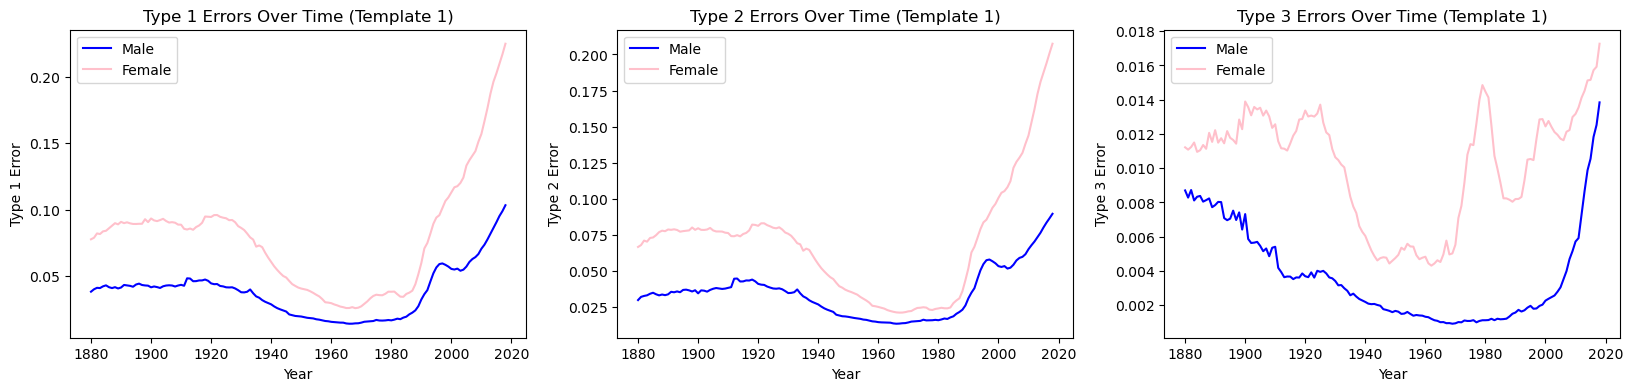

In [98]:
# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

import matplotlib.pyplot as plt
# TODO. 3pts

plt.figure(figsize=(20, 4))

# Type 1 
plt.subplot(1, 3, 1)
plt.plot(years, type1_errors_male, label="Male", color="blue")
plt.plot(years, type1_errors_female, label="Female", color="pink")
plt.xlabel("Year")
plt.ylabel("Type 1 Error")
plt.title(f"Type 1 Errors Over Time (Template 1)")
plt.legend()


# Type 2 
plt.subplot(1, 3, 2)
plt.plot(years, type2_errors_male, label="Male", color="blue")
plt.plot(years, type2_errors_female, label="Female", color="pink")
plt.xlabel("Year")
plt.ylabel("Type 2 Error")
plt.title(f"Type 2 Errors Over Time (Template 1)")
plt.legend()

# Type 3 
plt.subplot(1, 3, 3)
plt.plot(years, type3_errors_male, label="Male", color="blue")
plt.plot(years, type3_errors_female, label="Female", color="pink")
plt.xlabel("Year")
plt.ylabel("Type 3 Error")
plt.title(f"Type 3 Errors Over Time (Template 1)")
plt.legend()

## Template 2 Analysis

In [ ]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts

type1_errors_male = 
type1_errors_female = 

type2_errors_male = 
type2_errors_female = 

type3_errors_male = 
type3_errors_female = 


# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

import matplotlib.pyplot as plt
# TODO. 3pts

## Template 3 Analysis

In [ ]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts

type1_errors_male = 
type1_errors_female = 

type2_errors_male = 
type2_errors_female = 

type3_errors_male = 
type3_errors_female = 


# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

import matplotlib.pyplot as plt
# TODO. 3pts

## Template 4 Analysis

In [ ]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts

type1_errors_male = 
type1_errors_female = 

type2_errors_male = 
type2_errors_female = 

type3_errors_male = 
type3_errors_female = 


# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

import matplotlib.pyplot as plt
# TODO. 3pts

## Template 5 Analysis

In [ ]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts

type1_errors_male = 
type1_errors_female = 

type2_errors_male = 
type2_errors_female = 

type3_errors_male = 
type3_errors_female = 


# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

import matplotlib.pyplot as plt
# TODO. 3pts

## Template 6 Analysis

In [ ]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts

type1_errors_male = 
type1_errors_female = 

type2_errors_male = 
type2_errors_female = 

type3_errors_male = 
type3_errors_female = 


# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

import matplotlib.pyplot as plt
# TODO. 3pts

## Template 7 Analysis

In [ ]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts

type1_errors_male = 
type1_errors_female = 

type2_errors_male = 
type2_errors_female = 

type3_errors_male = 
type3_errors_female = 


# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

import matplotlib.pyplot as plt
# TODO. 3pts

## Template 8 Analysis

In [ ]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts

type1_errors_male = 
type1_errors_female = 

type2_errors_male = 
type2_errors_female = 

type3_errors_male = 
type3_errors_female = 


# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

import matplotlib.pyplot as plt
# TODO. 3pts

## Template 9 Analysis

In [ ]:
years = list(range(1880, 2019))

# the three types of errors for male and female
# each one should be a list of errors for years of 1880 to 2019

# TODO. 2pts

type1_errors_male = 
type1_errors_female = 

type2_errors_male = 
type2_errors_female = 

type3_errors_male = 
type3_errors_female = 


# visualize the three types of erros using the variables above.
# make three different figures
# Refer to Figure 2 of the paper

import matplotlib.pyplot as plt
# TODO. 3pts

### According to the plots you make, do you observe difference in the ability to recognize male and female names as PERSON entity types? How does the difference change over years? How does the difference change across different templates? Checking some error cases, where do you think the bias might come from? Can you think of any possible ways to mitigate the bias? 10pts.

#### <font color="red">Please type your response here.</font>
#### ***************